In [973]:
import numpy as np
import os

### functions

In [974]:
def split_covid_data(arr_path, normalize=True):
    covid_data = np.load(arr_path)
    covid_data = covid_data.astype(np.float32)
    
    if normalize: 
        data_mean = np.mean(covid_data, axis=1, keepdims=True)
        data_std = np.std(covid_data, axis=1, keepdims=True)
        covid_data = (covid_data - data_mean) / data_std
        stats_train = (data_mean[:709,:], data_std[:709,:])
        stats_val = (data_mean[709:798, :], data_std[709:798, :])
        stats_test = (data_mean[798:, :], data_std[798:,:])
        stats = (stats_train, stats_val, stats_test)
    else: 
        stats = None
    
    train_data = covid_data[:709,:]
    val_data = covid_data[709:798,:]
    test_data = covid_data[798:, :]

    # reshaping arrays:
    train_data = np.reshape(train_data, newshape=(train_data.shape[0], train_data.shape[1], 1))
    val_data = np.reshape(val_data, newshape=(val_data.shape[0], val_data.shape[1], 1))
    test_data = np.reshape(test_data, newshape=(test_data.shape[0], test_data.shape[1], 1))

    return train_data, val_data, test_data, stats

In [975]:
def rescale_covid_data(data_sample, stats, index):
    data_mean, data_std = stats
    mean, std = data_mean[index], data_std[index]
    data_sample = std * data_sample + mean
    data_sample = data_sample.astype(np.int32)
    return data_sample

In [976]:
covid_path = '../../data/covid_preprocess.npy'
train_data, val_data, test_data, stats = split_covid_data(covid_path)
stats_train, stats_val, stats_test = stats
train_data_unnorm, val_data_unnorm, test_data_unnorm, _ = split_covid_data(covid_path, normalize=False)

In [977]:
sum_test_data = np.sum(test_data_unnorm, axis=1)
print(np.max(sum_test_data))
print(np.argmax(sum_test_data))

20504.0
33


In [978]:
index = 88
N = 10

In [979]:
mean_preds_path = '../../output/covid_SMC_T/covid_Recurrent_T_depth_8_bs_32_fullmodel_True_dff_16_attn_w_None__p_10_SigmaObs_0.5_sigmas_0.5/mean_preds_sample_{}_N_{}.npy'.format(index, N)

distrib_path = '../../output/covid_SMC_T/covid_Recurrent_T_depth_8_bs_32_fullmodel_True_dff_16_attn_w_None__p_10_SigmaObs_0.5_sigmas_0.5/distrib_future_timesteps_sample_{}_N_{}.npy'.format(index, N)


In [980]:
mc_drop_1_path = '../../output/covid_rnn/covid_LSTM_units_16_pdrop_0.1_rnndrop_0.0_lr_0.001_bs_32_cv_False/mc_dropout_samples_sample_{}.npy'.format(index)

In [981]:
mean_preds_path = '../../output/covid_SMC_T/covid_Recurrent_T_depth_8_bs_32_fullmodel_True_dff_16_attn_w_None__p_10_SigmaObs_0.5_sigmas_0.5/mean_preds_sample_{}_N_{}_multi.npy'.format(index, N)

distrib_path = '../../output/covid_SMC_T/covid_Recurrent_T_depth_8_bs_32_fullmodel_True_dff_16_attn_w_None__p_10_SigmaObs_0.5_sigmas_0.5/distrib_future_timesteps_sample_{}_N_{}_multi.npy'.format(index, N)

In [982]:
mean_preds = np.load(mean_preds_path)
distrib_20_timsteps = np.load(distrib_path)

In [983]:
mean_preds_rescaled = rescale_covid_data(mean_preds, stats=stats_test, index=index)
mean_preds_rescaled.shape

(60,)

In [984]:
print(list(mean_preds_rescaled))

[2, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 2, 0, 0, 0, 1, 2, 0, 0, 0, 1, 8, 10, 12, 12, 16, 18, 19, 20, 20, 26, 29, 29, 32, 34, 38, 39, 42, 34, 31, 30, 29, 29, 29, 29, 29, 29, 29, 29, 30, 30, 30, 30, 30, 31, 30, 30, 30]


In [985]:
true_labels = test_data_unnorm[index, 1:].reshape(60)
print(true_labels.shape)
print(list(true_labels))

(60,)
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 9.0, 12.0, 12.0, 15.0, 17.0, 17.0, 19.0, 20.0, 25.0, 28.0, 28.0, 31.0, 32.0, 37.0, 38.0, 41.0, 42.0, 42.0, 42.0, 42.0, 45.0, 48.0, 48.0, 50.0, 50.0, 50.0, 51.0, 54.0, 55.0, 56.0, 56.0, 56.0, 56.0, 57.0, 57.0, 60.0, 60.0]


In [986]:
import matplotlib.pyplot as plt

In [987]:
x = np.linspace(1,60,60)

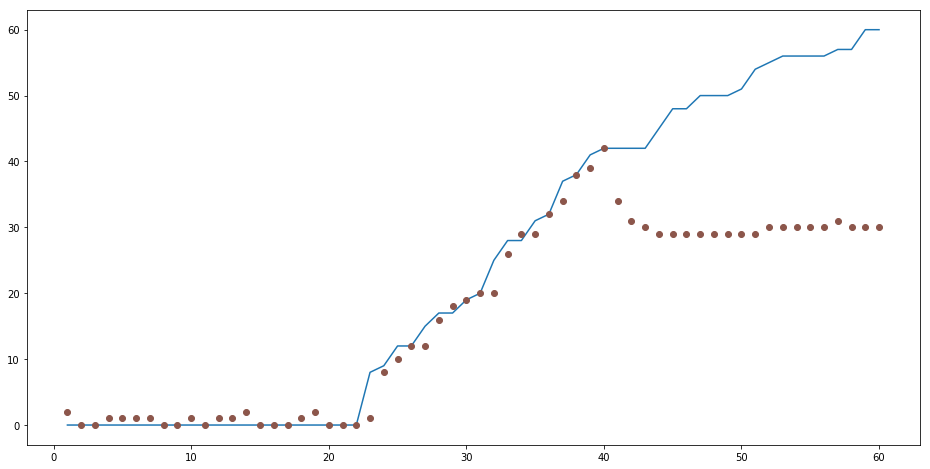

In [988]:
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(x, true_labels, '-')
ax.plot(x, mean_preds_rescaled, 'o', color='tab:brown')

### confidence intervals computation

In [989]:
distrib_20_timsteps.shape
distrib_20_timsteps[:,0]

array([ 0.59621918,  0.13343403,  0.11517307,  0.17527267,  0.21940339,
        0.21429783,  0.18706425, -0.0028654 ,  0.57425976,  0.25332904,
        0.11607815,  0.56922054,  0.18798819,  0.59908533,  0.67637908,
       -0.05578807,  0.37135032,  0.27411002,  0.12809412,  0.18116784])

In [990]:
distrib_rescaled = rescale_covid_data(distrib_20_timsteps, stats=stats_test, index=index)
distrib_rescaled[:,0]

array([37, 27, 26, 28, 29, 28, 28, 23, 37, 29, 26, 36, 28, 37, 39, 22, 32,
       30, 26, 28], dtype=int32)

In [991]:
distrib_mean = np.mean(distrib_rescaled, axis=1)
print(distrib_mean.shape)
distrib_mean[0]

(20,)


33.819

In [992]:
distrib_std = np.std(distrib_rescaled, axis=1)
distrib_std[0]

4.025448919064805

In [993]:
def pad_array(array):
    pad_distrib = np.zeros(shape=60)
    pad_distrib[40:] = array
    return pad_distrib

In [994]:
pad_distrib_mean = pad_array(distrib_mean)
pad_distrib_std = pad_array(distrib_std)

In [995]:
distrib_rescaled.shape[1]**(1/2)

31.622776601683793

In [996]:
lower_bound = pad_distrib_mean - 1.960 * pad_distrib_std / (distrib_rescaled.shape[1]**(1/2))
upper_bound = pad_distrib_mean + 1.960 * pad_distrib_std / (distrib_rescaled.shape[1]**(1/2))
#lower_bound = pad_distrib_mean - 1.960 * pad_distrib_std
#upper_bound = pad_distrib_mean + 1.960 * pad_distrib_std

In [997]:
upper_bound_max = np.max(distrib_rescaled, axis=1)
lower_bound_min = np.min(distrib_rescaled, axis=1)
lower_bound_min = pad_array(lower_bound_min)
upper_bound_max = pad_array(upper_bound_max)

In [998]:
lower_bound.shape

(60,)

In [999]:
print('lower bound min', list(lower_bound_min))
print('upper bound max', list(upper_bound_max))

lower bound min [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 13.0, 15.0, 16.0, 14.0, 15.0, 16.0, 16.0, 12.0, 13.0, 14.0, 16.0, 6.0, 13.0, 10.0, 14.0, 14.0, 15.0, 15.0, 15.0]
upper bound max [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 50.0, 46.0, 45.0, 43.0, 47.0, 44.0, 48.0, 43.0, 44.0, 48.0, 46.0, 43.0, 47.0, 43.0, 45.0, 47.0, 48.0, 45.0, 46.0, 45.0]


In [1000]:
#upper_bound

Text(0.5,1,'predicted versus true covid deaths with error bars from day 40 - sample 88 - multistep prediction')

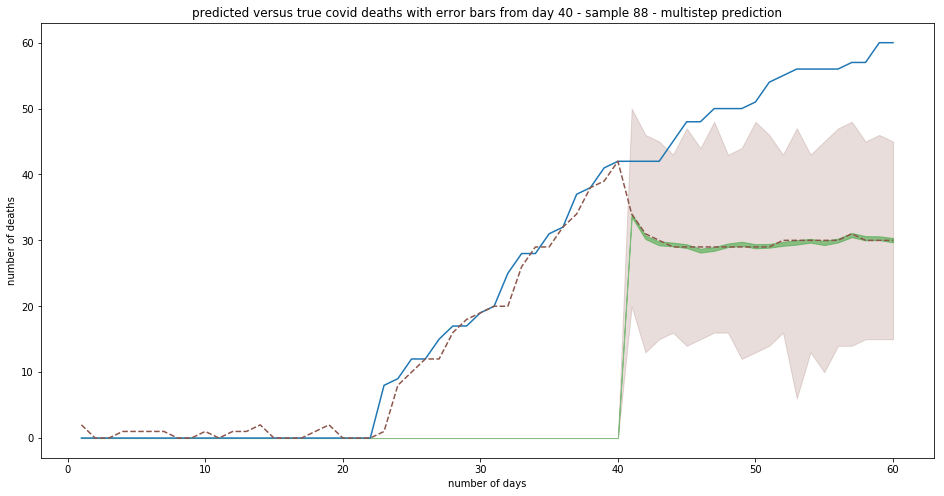

In [1001]:
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(x, true_labels, '-', label='true data')
ax.plot(x, mean_preds_rescaled, '-', linestyle='dashed', color='tab:brown', label='mean predicted data')
ax.fill_between(x, lower_bound_min, upper_bound_max, alpha=0.2, color='tab:brown')
ax.fill_between(x, lower_bound, upper_bound, alpha=0.5, color='tab:green')
ax.set_xlabel('number of days')
ax.set_ylabel('number of deaths')
title = "predicted versus true covid deaths with error bars from day 40 - sample {} - multistep prediction".format(index)
ax.set_title(title)

In [1002]:
#out_path = '../../output/covid_SMC_T/covid_Recurrent_T_depth_8_bs_32_fullmodel_True_dff_16_attn_w_None__p_10_SigmaObs_0.5_sigmas_0.5' 

#fig_path = os.path.join(out_path, 'multistep_prediction_sample_{}_N_{}'.format(index, N))
#fig.savefig(fig_path)
#a.savefig(fig_path, bbox_inches='tight')


### adding mc dropout

In [1003]:
mc_samples = np.load(mc_drop_1_path)
#mc_samples = mc_samples_1.reshape(mc_samples_1.shape[1], mc_samples_1.shape[2])
mc_samples.shape

(1000, 60)

In [1004]:
mc_samples = rescale_covid_data(data_sample=mc_samples, stats=stats_test, index=index)

In [1005]:
lstm_preds = np.mean(mc_samples, axis=0)

In [1006]:
print(list(true_labels))
print(list(lstm_preds))

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 9.0, 12.0, 12.0, 15.0, 17.0, 17.0, 19.0, 20.0, 25.0, 28.0, 28.0, 31.0, 32.0, 37.0, 38.0, 41.0, 42.0, 42.0, 42.0, 42.0, 45.0, 48.0, 48.0, 50.0, 50.0, 50.0, 51.0, 54.0, 55.0, 56.0, 56.0, 56.0, 56.0, 57.0, 57.0, 60.0, 60.0]
[23.771, 23.804, 23.86, 23.935, 23.956, 24.022, 24.061, 24.006, 24.039, 24.078, 24.047, 24.101, 24.051, 24.041, 24.103, 24.049, 24.216, 24.111, 24.083, 24.094, 24.046, 24.085, 24.072, 24.013, 24.028, 24.041, 24.095, 24.029, 23.991, 23.985, 23.947, 23.954, 23.976, 23.936, 23.908, 23.85, 23.658, 23.318, 23.203, 23.203, 23.088, 22.943, 22.85, 22.718, 22.48, 22.357, 22.264, 22.11, 22.052, 21.942, 21.603, 21.447, 21.362, 21.288, 21.127, 21.092, 21.048, 20.957, 20.704, 20.632]


In [1007]:
mc_samples = mc_samples[:,40:]

In [1008]:
mc_samples.shape

(1000, 20)

In [1009]:
mc_mean = np.mean(mc_samples, axis=0)
mc_std = np.std(mc_samples, axis=0)
mc_max = np.max(mc_samples, axis=0)
mc_min = np.min(mc_samples, axis=0)
pad_mc_mean = pad_array(mc_mean)
pad_mc_std = pad_array(mc_std)
pad_mc_max = pad_array(mc_max)
pad_mc_min = pad_array(mc_min)
mc_lb = pad_mc_mean - 1.960 * pad_mc_std / (mc_samples.shape[0]**(1/2))
mc_ub = pad_mc_mean + 1.960 * pad_mc_std / (mc_samples.shape[0]**(1/2))

Text(0.5,1,'True data versus LSTM predictions with error bars from MC-Dropout samples (from day 40) - sample 88')

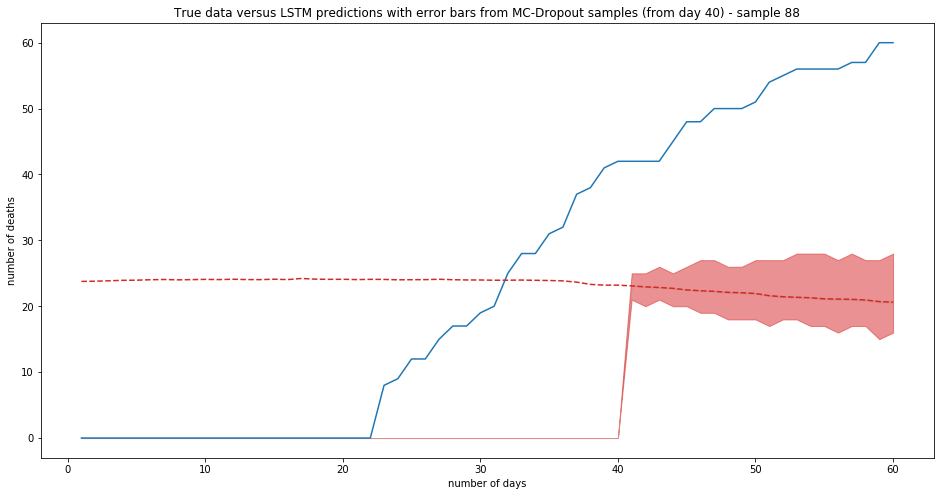

In [1010]:
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(x, true_labels, '-', label='true data')
ax.plot(x, lstm_preds, '-', linestyle='dashed', color='tab:red', label='LSTM predictions')
ax.fill_between(x, mc_lb, mc_ub, alpha=0.1, color='tab:green')
ax.fill_between(x, pad_mc_min, pad_mc_max, alpha=0.5, color='tab:red')
ax.set_xlabel('number of days')
ax.set_ylabel('number of deaths')
title='True data versus LSTM predictions with error bars from MC-Dropout samples (from day 40) - sample {}'.format(index)
ax.set_title(title)

In [1011]:
lstm_out_path = '../../output/covid_rnn/covid_LSTM_units_16_pdrop_0.1_rnndrop_0.0_lr_0.001_bs_32_cv_False'
fig_path = os.path.join(lstm_out_path, 'lstm_preds_sample_{}'.format(index))
fig.savefig(fig_path)